In [3]:
from ray.tune.search.bayesopt import BayesOptSearch
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import copy
import numpy as np
import pandas as pd
import os
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.distributions import Normal, beta
from torch.utils.data import DataLoader
from torchmetrics.regression import R2Score

In [4]:
PREDICT_PROPERTIES=['sand']

def get_spectra_data(train_csv, test_csv=None,mineral=False,target_dataframe=None,over_write_csv=False):


    SPECTRA_COLUMN_STARTING = "nir."
    ID=['labSampleId']

    # check if this is a target and make the target csv to be the same with the global file used for training
    if isinstance(train_csv, list):
        df_source = pd.concat(map(pd.read_csv, train_csv), ignore_index=True)
        #remove spectra signal which is more than 1
        print("removing out of bound spectra from source")

        #subset only the mineral from the lucas data
        if mineral:
            reflectance_out_of_bound = df_source.loc[df_source[df_source[df_source.columns[pd.Series(df_source.columns).str.startswith(SPECTRA_COLUMN_STARTING)]] > 1].dropna(
            how='all', axis=0).index]
            df_source = df_source.loc[set(df_source.index) - set(reflectance_out_of_bound.index)]

            if 'mineral' in df_source.columns:
                df_source=df_source.loc[df_source['mineral'] == 'mineral']


    if target_dataframe is not None:
        df_target = target_dataframe

    if isinstance(test_csv, list) and target_dataframe is None:
        df_target = pd.concat(map(pd.read_csv, test_csv), ignore_index=True)

        # remove spectra signal which is more than 1
        print("removing out of bound spectra from target")

        if mineral:
            reflectance_out_of_bound = df_target.loc[df_target[df_target[df_target.columns[
                pd.Series(df_target.columns).str.startswith(SPECTRA_COLUMN_STARTING)]] > 1].dropna(
                how='all', axis=0).index]

            df_target = df_target.loc[set(df_target.index) - set(reflectance_out_of_bound.index)]

    #common_cols = list(set.intersection(set(df_target), set(df_source)))
    #print(common_cols)

    common_cols = df_source.columns.intersection(df_target.columns)

    # use this list to perform column selection
    df_target_ = df_target[common_cols]
    df_source_ = df_source[common_cols]


    # extract properties for source and target
    df_source_ = df_source_.filter(regex='^(nir.|sand|labSampleId)')
    df_target_ = df_target_.filter(regex='^(nir.|sand|labSampleId)')



    # Define the character to remove
    character_to_remove = 'nir.'

    # Remove the character from column names
    df_source_.columns = df_source_.columns.str.replace(character_to_remove, '')
    df_target_.columns = df_target_.columns.str.replace(character_to_remove, '')


    # Extract column names with numbers greater than the threshold
    source_columns_to_drop = [col for col in df_source_.filter(regex='^(nir.)').columns if int(col) > 4000]
    target_columns_to_drop = [col for col in df_target_.filter(regex='^(nir.)').columns if int(col) > 4000]

    # Drop the selected columns from the DataFrame
    df_source_ = df_source_.drop(columns=source_columns_to_drop)
    df_target_ = df_target_.drop(columns=target_columns_to_drop)


    #split train datasest into train and amin_val_loss
    from sklearn.model_selection import train_test_split
    df_source_train, df_source_val= train_test_split(df_source_,  test_size=0.2, random_state=42)



    df_source_train_= df_source_train.drop(columns=PREDICT_PROPERTIES)
    df_source_val_= df_source_val.drop(columns=PREDICT_PROPERTIES)
    df_target__= df_target_.drop(columns=PREDICT_PROPERTIES)

    df_source_spectral_train = get_spectra(df_source_train_)

    df_source_spectral_val = get_spectra(df_source_val_)
    print(len(df_source_spectral_train))
    print(len(df_source_spectral_val))


    df_target_spectral = get_spectra(df_target__)
    print(len(df_target_spectral))

    if over_write_csv:
        pd.DataFrame(df_source_spectral_train).head(2).to_csv("../Data/sand_source_file.csv", index=False)

    df_source_spectral_train=df_source_spectral_train.to_numpy()
    df_source_spectral_val=df_source_spectral_val.to_numpy()
    df_target_spectral=df_target_spectral.to_numpy()

    print(df_source_spectral_train.shape)

    for i in range(len(PREDICT_PROPERTIES)):
        if PREDICT_PROPERTIES[i] not in df_source_train.columns:
            df_source_train[PREDICT_PROPERTIES[i]] =df_source_train[PREDICT_PROPERTIES[i]]

        if PREDICT_PROPERTIES[i] not in df_source_val.columns:
            df_source_val[PREDICT_PROPERTIES[i]] =df_source_val[PREDICT_PROPERTIES[i]]

        if PREDICT_PROPERTIES[i] not in df_target_.columns and PREDICT_PROPERTIES[i] in  df_target:
            df_target_[PREDICT_PROPERTIES[i]] =df_target[PREDICT_PROPERTIES[i]]

    # remove the 2500 column in the USA/NZ data
    #df_source = df_source.drop([SPECTRA_COLUMN_STARTING, SPECTRA_COLUMN_STARTING + '2500'], axis=1, errors='ignore')
    #df_target = df_target.drop([SPECTRA_COLUMN_STARTING, SPECTRA_COLUMN_STARTING + '2500'], axis=1, errors='ignore')

    return df_source_train, df_source_val,df_target_, df_source_spectral_train,df_source_spectral_val, df_target_spectral


def get_spectra(df):

    filter_col = [col for col in df.columns]

    data = df[filter_col]

    data=data.iloc[:, 2::10]


    return data



In [6]:
import pandas as pd
GLOBAL_CSV=[ "C:/Projects/SmapProjects/SpectraData2023/mir_texture_cali.csv"]
#df_sources, df_targets, df_sources_spectral, df_targets_spectral=get_spectra_data(train_csv=GLOBAL_CSV,target_dataframe=df)

TARGET_CSV=[ "C:/Projects/SmapProjects/SpectraData2023/mir_texture_val.csv"]
df_source_train, df_source_val,df_target, df_source_spectral_train, df_source_spectral_val,df_target_spectral=get_spectra_data(train_csv=GLOBAL_CSV,test_csv=TARGET_CSV,over_write_csv=True)


X_train_raw = df_source_spectral_train#.reshape(df_source_spectral_train.shape[0], df_source_spectral_train.shape[1], 1)
#X_train=np.log(1 / X_train)
y_train = np.array(df_source_train[PREDICT_PROPERTIES].values)

X_val_raw = df_source_spectral_val#.reshape(df_source_spectral_val.shape[0], df_source_spectral_val.shape[1], 1)
y_val= np.array(df_source_val[PREDICT_PROPERTIES].values)


X_test_raw =df_target_spectral#.reshape(df_target_spectral.shape[0], df_target_spectral.shape[1], 1)
y_test =df_target[PREDICT_PROPERTIES].values

removing out of bound spectra from source
removing out of bound spectra from target
2412
604
1005
(2412, 340)


In [7]:
df_source_val

,labSampleId,sand,4000,3999,3998,3997,3996,3995,3994,3993,...,609,608,607,606,605,604,603,602,601,600
63,SB10134B,2.070000,-0.074913,-0.075331,-0.075767,-0.076227,-0.076636,-0.076476,-0.074446,-0.069726,...,-2.907370,-2.949399,-2.862831,-2.670668,-2.419237,-2.119185,-1.775398,-1.428811,-1.094719,-0.778498
2808,SB09894C,66.209999,-0.047917,-0.047805,-0.047687,-0.047565,-0.047452,-0.047326,-0.047063,-0.046522,...,0.603775,0.605955,0.611350,0.621533,0.637356,0.658497,0.683174,0.708055,0.732013,0.754703
102,SB09842E,55.630001,-0.076082,-0.079010,-0.082063,-0.085302,-0.088164,-0.090187,-0.092096,-0.093131,...,-2.526272,-2.665675,-2.753467,-2.788477,-2.773178,-2.718126,-2.641012,-2.563073,-2.489146,-2.418586
2692,SB09745B,63.259998,-0.110468,-0.111472,-0.112524,-0.113588,-0.114633,-0.115279,-0.114402,-0.111095,...,-0.468744,-0.444032,-0.424865,-0.412824,-0.407294,-0.409310,-0.418121,-0.427112,-0.435122,-0.443024
416,M18/0291,19.000000,-0.083878,-0.084949,-0.086063,-0.087265,-0.088286,-0.088509,-0.087096,-0.083157,...,-2.701379,-2.822400,-2.850712,-2.786940,-2.651300,-2.450232,-2.197872,-1.943115,-1.699641,-1.468165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,M17/7911,21.000000,-0.090098,-0.090718,-0.091368,-0.092011,-0.092674,-0.093187,-0.092868,-0.091343,...,-2.656169,-2.794697,-2.843566,-2.806568,-2.702206,-2.539186,-2.332690,-2.124212,-1.925092,-1.735724
231,M18/0811,21.000000,-0.080462,-0.081107,-0.081777,-0.082507,-0.083111,-0.083062,-0.081519,-0.077925,...,-2.980524,-3.094550,-3.129518,-3.083343,-2.969656,-2.795273,-2.575735,-2.354108,-2.142313,-1.940948
637,SB09963C,10.037003,-0.085436,-0.085541,-0.085652,-0.085755,-0.085874,-0.085871,-0.085200,-0.083394,...,-2.115041,-2.256682,-2.295815,-2.241302,-2.119427,-1.941005,-1.719844,-1.496625,-1.283015,-1.080069
1034,SB10004E,4.445000,-0.036036,-0.037472,-0.038972,-0.040534,-0.041974,-0.043056,-0.043747,-0.043782,...,-2.354397,-2.438833,-2.449846,-2.392724,-2.285748,-2.135217,-1.950689,-1.764472,-1.586103,-1.416722


In [8]:
# Standardizing data
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
scaler.fit(X_val_raw)
X_val = scaler.transform(X_val_raw)

X_test = X_test_raw

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

In [9]:
def evaluate(model,test_x,test,type="mae",sample_size = 100):
    df =evaluate_soil_property(model,test_x,sample_size = sample_size)

    result_total_pret= pd.DataFrame(columns=['upper', 'lower','pred', 'obs'])

    result_total_pret['pred'] = df['pred']

    result_total_pret['lower'] =df['lower']
    result_total_pret['upper'] =df['upper']

    result_total_pret['obs']=test[:,0]

    if type=="mae":
        r2_total_pret =mean_absolute_error(test[:,0],result_total_pret['pred'])
    elif type=="r2":
        r2_total_pret =r2_score(test[:,0],result_total_pret['pred'])
    elif type=="mse":
        r2_total_pret =mean_squared_error(test[:,0],result_total_pret['pred'])
    elif type=="rmse":
        r2_total_pret=np.sqrt(mean_squared_error(test[:,0],result_total_pret['pred']))


    return r2_total_pret


from scipy.stats import norm
def evaluate_soil_property(model,
                         test,
                        sample_size = 100):

     df = pd.DataFrame(columns=['lower','upper','pred'])

     with torch.no_grad():

        model.eval()
        scaler = StandardScaler()
        scaler.fit(test)
        predictions=[]
        test = scaler.transform(test)
        test = torch.tensor(test, dtype=torch.float32)
        for _ in range(sample_size):

            output = model(test)  # Replace 'input_data' with your test input
            predictions.append(output.numpy())

        predictions = torch.tensor(predictions)

        prediction_mean = (torch.mean(predictions, dim=0)).detach().numpy()


        prediction_std = torch.std(predictions, dim=0).detach().numpy()

        # Calculate lower and upper bounds for the prediction interval (e.g., 95% interval)
        lower_bound_ = prediction_mean - (1.645 * prediction_std)
        upper_bound_ = prediction_mean + (1.645 * prediction_std)


        for i in range(0,len(prediction_mean)):

            #get the first element since we ar predicting just one at a time
            sample_pred = prediction_mean[i][0]

            lower_bound = lower_bound_[i][0]
            upper_bound = upper_bound_[i][0]

            # Check and adjust upper bound if greater than 100
            upper_bound = min(upper_bound, 99.9)

            # Check and adjust prediction if greater than 100
            sample_pred = min(sample_pred, 99.5)

            row = {'upper':upper_bound,'lower':abs(lower_bound),'pred':sample_pred}

            df.loc[i] = row
        return df


## 2. Define Model

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal,Uniform

class BayesianCNN(nn.Module):
    def __init__(self, num_feature: int, dims=[512, 28, 64], bias_mean=0.0003,weight_mean=0.0002,weight_std=0.0001, bias_std=0.0005):
        super(BayesianCNN, self).__init__()

        # Define the fully connected layers based on the specified dimensions
        self.fc_layers = nn.ModuleList()
        in_dim = num_feature
        for out_dim in dims:
            self.fc_layers.append(nn.Linear(in_dim, out_dim))
            in_dim = out_dim

        self.fc_out = nn.Linear(in_dim, 1)  # Output layer for pret

        # Update the dimensions of weight_mu and weight_rho to match the output dimension
        self.weight_dim = out_dim
        self.weight_mu = nn.Parameter(torch.Tensor(1, self.weight_dim))
        self.weight_rho = nn.Parameter(torch.Tensor(1, self.weight_dim))

        self.bias_mu = nn.Parameter(torch.Tensor(1))
        self.bias_rho = nn.Parameter(torch.Tensor(1))
        self.weight_std = weight_std
        self.bias_std = bias_std
        self.weight_mean = weight_mean
        self.bias_mean = bias_mean

        # Initialize parameters
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weight means close to zero and standard deviations to be small
        nn.init.normal_(self.weight_mu, self.weight_mean, std=self.weight_std)
        nn.init.normal_(self.weight_rho, self.weight_mean, std=self.weight_std)

        # Initialize bias means close to zero and standard deviations to be small
        nn.init.normal_(self.bias_mu, self.bias_mean, std=self.bias_std)
        nn.init.normal_(self.bias_rho, self.bias_mean, std=self.bias_std)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input

        # Pass through fully connected layers with specified dimensions
        for fc_layer in self.fc_layers:
            x = F.rrelu(fc_layer(x))
            #Dropout randomly deactivates a fraction of neurons during training,
            # which can help prevent overfitting.
            #x = F.dropout(x,p=0.30)


        # Re-parameterization trick for sampling weights
        #To reduce variability, you can reduce the standard deviation of this sampling.
        weight_epsilon = Normal(0.0,1).sample(self.weight_mu.size())
        weight_sigma = torch.log(1 + torch.exp(self.weight_rho))
        weight = self.weight_mu + (weight_sigma * weight_epsilon)

        bias_epsilon = Normal(0.0,1).sample(self.bias_mu.size())
        bias_sigma = torch.log(1 + torch.exp(self.bias_rho))
        bias = self.bias_mu + (bias_sigma * bias_epsilon)

        # Enforce non-negativity on weights and biases
        weight = torch.clamp(weight, min=0)
        bias = torch.clamp(bias, min=0)


        # Final linear layer operation
        output = F.linear(x, weight, bias)
        # Apply sigmoid activation to squash values between 0 and 1
        output = torch.sigmoid(output)

        # Scale the values to the desired range (0 to 100)
        output = output * 100

        return output

In [11]:
train = torch.utils.data.TensorDataset(X_train,y_train)
train_dataloader = DataLoader(train, batch_size=16)

val= torch.utils.data.TensorDataset(X_val,y_val)
val_dataloader = DataLoader(val, batch_size=16)

test= torch.utils.data.TensorDataset(X_test,y_test)
test_dataloader = DataLoader(test, batch_size=16)


In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

#Manually compute the L1 loss over all model parameters:
def l1_penalty(model):
    l1_loss = 0.0
    for param in model.parameters():
        l1_loss += torch.abs(param).sum()
    return l1_loss

def train_epoch(train,val,model,loss_fn,optimizer,batch_size,n_epochs):

    train_dataloader = DataLoader(train, batch_size=batch_size)
    model.train()
    for epoch in range(n_epochs):
        for inputs, targets in train_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

        # Print the training loss for this epoch
        print(f"Epoch [{epoch+1}/{n_epochs}] Loss: {loss.item():.5f}")
        #evaluate accuracy at end of each epoch
        test_epoch(val,model, loss_fn ,optimizer,batch_size,n_epochs)


def test_epoch(val,model,loss_fn,optimizer,batch_size,n_epochs):
    val_dataloader = DataLoader(val, batch_size=batch_size)
    val_loss=0
    model.eval()
    for inputs, targets in val_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            val_loss += loss.item()
            loss.backward()
            optimizer.step()

        # Print the training loss for this epoch
    avg_val_loss = val_loss / len(inputs)
    print(f"Epoch [{n_epochs+1}/{n_epochs}] Val Loss: {loss.item():.5f}")


    return avg_val_loss


def get_metrics(test,y_test,model):
    loss_fn = nn.MSELoss()

    model.eval()

    y_pred = model(test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    rmse= np.sqrt(mse)

    test_result= evaluate_soil_property(model,test)
    test_result["obs"] = y_test
    pcip = calculate_pcip(test_result["obs"], test_result['lower'], test_result['upper'])
    r2score = R2Score()
    r2= r2score(y_pred, y_test).item()

    r2_pent =r2*100
    #Balancing Trade-offs between r2 and pcip:
    score_avg = (pcip +  r2_pent)/2
    print(f'MSE: {mse:.4f},R2: {r2:.4f},RMSE: {rmse:.4f}, PCIP: {pcip:.2f},score_avg:{score_avg:.4f}')
    return [mse,r2,rmse,pcip]

def calculate_pcip(y_true, lower_bounds, upper_bounds):
    num_samples = len(y_true)
    num_covering_intervals = np.sum((lower_bounds <= y_true) & (y_true <= upper_bounds))
    pcip = (num_covering_intervals / num_samples) * 100
    return pcip

Using cpu device


## 2. Hyperparamter tuning to find best Architecture

In [31]:
from ray.tune.search.optuna import OptunaSearch
import torch
import torch.optim as optim
import ray
from ray.air import session, Checkpoint
from ray.tune.schedulers import PopulationBasedTraining, HyperBandForBOHB
from ray.tune.schedulers import AsyncHyperBandScheduler
from enum import Enum
loss_fn = nn.MSELoss()


class Optimiser(str, Enum):
    Adams = "Adams"
    SGD ="SGD"
    Adadelta = "Adadelta"
    Adagrad = "Adagrad"
    Adamax = "Adamax"
    Nadam = "Nadam"
    Ftrl = "Ftrl"
    RMSprop="RMSprop"
    LBFGS ="LBFGS"
    #LBFGS ="LBFGS"
    def __str__(self):
        return self.value

 # set your desired L1 regularization strength
def objective(config):  # ①

    #dataset
    train = torch.utils.data.TensorDataset(X_train,y_train)

    val= torch.utils.data.TensorDataset(X_val,y_val)


    #dim = random.sample(output_dims, config["n_layers"])

    criterion=nn.MSELoss()

    #  dimensions to select
    dims = config["dims"]  # You can change this to any number you want



    model = BayesianCNN(num_feature=X_train.shape[1],dims=dims,
                           weight_std=config["weight_std"],
                          bias_std=config["bias_std"],
                        bias_mean=config["bias_mean"],weight_mean=config["weight_mean"]).to("cpu")   # Create a PyTorch conv net

    if config["optimiser"] == Optimiser.RMSprop:
        optimizer = torch.optim.RMSprop(model.parameters(), momentum=config["opt_momentum"], lr=config["lr"])
    elif config["optimiser"] == Optimiser.LBFGS:
        optimizer = torch.optim.LBFGS(model.parameters(),  lr=config["lr"])
    elif config["optimiser"] == Optimiser.Adams:
        optimizer = torch.optim.Adam(model.parameters(),  lr=config["lr"])
    elif config["optimiser"] == Optimiser.SGD:
        optimizer = torch.optim.SGD(model.parameters(),  lr=config["lr"],momentum=config["opt_momentum"])
    elif config["optimiser"] == Optimiser.Nadam:
        optimizer = torch.optim.NAdam(model.parameters(),  lr=config["lr"],momentum_decay=config["opt_momentum"])

    checkpoint = session.get_checkpoint()

    if checkpoint:
        checkpoint_state = checkpoint.to_dict()
        with checkpoint.as_directory() as dir_path:
            print("test")
            model_state, optimizer_state = torch.load(os.path.join(dir_path, "checkpoint.pt"))

            # Load optimizer state (needed since we're using momentum),
            # then set the `lr` and `momentum` according to the config.
            optimizer.load_state_dict(optimizer_state)
            model.load_state_dict(model_state)
        for param_group in optimizer.param_groups:
            if "lr" in config:
                param_group["lr"] = config["lr"]
            if "opt_momentum" in config:
                param_group["opt_momentum"] = config["opt_momentum"]

    while True:

        train_epoch(train,val,model, criterion ,optimizer,config["batch_size"],config["epochs"])  # Train the model

        os.makedirs("model", exist_ok=True)
        torch.save(
            (model.state_dict(), optimizer.state_dict()), "model/checkpoint.pt")

        mse,r2,rmse,pcip = get_metrics(X_test,y_test,model)  # Compute test accuracy
        #optimise with pcip and r2
        r2_pent =r2*100
        score_avg = (pcip+r2_pent)/2
        checkpoint = Checkpoint.from_directory("model")

        session.report({"done": pcip > 99 and rmse < 0.25,"mse": mse, "r2": r2,"rmse": rmse, "pcip": pcip,"score_avg":score_avg},checkpoint=checkpoint)  # Report to Tune

##### RUN  ##############
import ray
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.search import ConcurrencyLimiter
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.schedulers.pb2 import PB2
from ray.tune import tune
import random

ray.shutdown()


# Your original list of dimensions
original_dims = [512, 256,  128, 64, 32,  16,  8, 512,256,128,64,28]
# List of optimizer names
optimizer_names = ["Adams", "SGD","Nadam"]
optimizer_names = ["Adams", "Nadam"]
ray.init(num_cpus=12, num_gpus=0,_temp_dir="/ray") # assign the total # of cpus and gpus, make sure you have ray.init in the beginning and ray.shutdown at the end
sched = AsyncHyperBandScheduler(  time_attr="training_iteration",
    reduction_factor=2,
    metric='rmse',
    mode='min')  # set a scheduler

perturbation_interval = 10
#use population based training
scheduler =PopulationBasedTraining(
       time_attr="training_iteration",
    perturbation_interval=perturbation_interval,
    metric="rmse",
    mode="min",
    quantile_fraction=0.25,  # copy bottom % with top %
    #hyperparam_mutation - for pbt
    hyperparam_mutations={
        # distribution for resampling
        "lr": [0.0001, 0.1],
        "momentum": [0.009,0.01],
        "opt_momentum": [0.009,0.01],
    }
)
algo =OptunaSearch(metric=["rmse","pcip"], mode=["min","max"])# HyperOptSearch() # if you want to use the Bayesian optimization, import BayesOptSearch instead
algo = ConcurrencyLimiter(algo, max_concurrent=8)
scheduler = HyperBandForBOHB(
    time_attr="training_iteration",
    max_t=20,
    #metric="rmse",
    #mode='min',
    reduction_factor=0.25,
    stop_last_trials=False,
)
scheduler = PB2(
    time_attr="training_iteration",
    perturbation_interval=perturbation_interval,
    metric="score_avg",
    mode="max",
    quantile_fraction=0.4,  # copy bottom % with top %
    #hyperparam_mutation - for pbt
    hyperparam_bounds={
        # distribution for resampling
        "lr": [0.00001, 0.1],
        "momentum": [0.009,0.01],
        "opt_momentum": [0.009,0.01],
    },
)
analysis = tune.run(
        objective,   # the core training/testing of your model
        #storage_path=os.getcwd(), # for saving the log files
        name="pbt_sand", # name for the result directory
        #resume="REMOTE",
        #metric="rmse",
        #resume="PROMPT",
        #mode='min',
        #search_alg=algo,
        scheduler=scheduler,
        stop={
                "training_iteration": 20,
                "done": True,
                "rmse": 0.05,
        },
        resources_per_trial={
                "cpu": 1,
                "gpu": 0
         },
        num_samples=30, # 50 trials
        progress_reporter=ray.tune.JupyterNotebookReporter(metric="score_avg",overwrite=True,max_report_frequency=7),
        config={

               "lr": ray.tune.loguniform(0.00001, 0.1),
                  #"pred_interval_constant":ray.tune.loguniform(0.28, 12.05),
                 "momentum": ray.tune.loguniform(0.009,0.01),
                 "weight_std": ray.tune.loguniform(0.0001,10.02),
                 "weight_mean": ray.tune.loguniform(0.0001,10.02),
                 "bias_mean": ray.tune.loguniform(0.0001,10.02),
                 "bias_std": ray.tune.loguniform(0.01, 17.7),
                 "batch_size": ray.tune.randint(2,128),
                 "epochs":ray.tune.randint(2,1000),
                 "dims": ray.tune.sample_from(lambda spec: random.choices(original_dims,k=random.randint(2, 7))),
                 "optimiser": ray.tune.sample_from(lambda spec: random.choice(optimizer_names)),
                 "checkpoint_interval": perturbation_interval
        })

2023-11-24 10:18:30,185	INFO tune.py:657 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2023-11-24 10:18:30,419	INFO tensorboardx.py:178 -- pip install "ray[tune]" to see TensorBoard files.
2023-11-24 10:18:30,420	WARNING callback.py:144 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


ValueError: You called resume (PROMPT) when no checkpoint exists in local directory (C:\Users\omondiagbep\ray_results\pbt_carbon). If you want to start a new experiment, use `resume="AUTO"` or `resume=None`. If you expected an experiment to already exist, check if you supplied the correct `local_dir` to `air.RunConfig()`.

In [105]:
best_trials = analysis.get_best_trial("score_avg", "max", "all")
print(f"Best trial config: {best_trials.config}")
print(f"Best trial final validation mse: {best_trials.last_result['mse']}")
print(f"Best trial final validation r2: {best_trials.last_result['r2']}")
print(f"Best trial final validation rmse: {best_trials.last_result['rmse']}")
print(f"Best trial final validation pcip: {best_trials.last_result['pcip']}")
#print(f"Best trial final validation score_avg: {best_trials.last_result['optimal_dim']}")
#print(f"Best trial final validation l1_coef: {best_trial.last_result['l1_coef']}")
best_checkpoints = best_trials.checkpoint.to_air_checkpoint()


Best trial config: {'lr': 0.0004056961680898992, 'momentum': 0.009068718679849, 'weight_std': 0.0015744750485797052, 'bias_std': 0.1327185360434992, 'batch_size': 86, 'num_dims': 3, 'epochs': 243, 'dims': [8, 32, 32, 256, 128, 8], 'optimiser': 'Adams', 'checkpoint_interval': 10, 'opt_momentum': 0.00921318133493377}
Best trial final validation mse: 0.7724632620811462
Best trial final validation r2: 0.9489880800247192
Best trial final validation rmse: 0.8788988918420289
Best trial final validation pcip: 91.08635097493037


In [106]:
gpus_per_trial = 2
best_trained_model=BayesianCNN(num_feature=X_train.shape[1],dims=best_trials.config["dims"],
                           weight_std=best_trials.config["weight_std"],
                          bias_std=best_trials.config["bias_std"],
                               bias_mean=best_trials.config["bias_mean"],weight_mean=best_trials.config["weight_mean"])

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if gpus_per_trial > 1:
        best_trained_model = nn.DataParallel(best_trained_model)
best_trained_model.to(device)
with best_checkpoints.as_directory() as dir_path:
    print(dir_path)
    model_state, optimizer_state = torch.load(os.path.join(dir_path, "checkpoint.pt"))
    best_trained_model.load_state_dict(model_state)
best_checkpoint_data = best_checkpoints.to_dict()



C:\Users\omondiagbep\ray_results\pbt_carbon\objective_2aefe_00005_5_batch_size=86,bias_std=0.1327,epochs=243,lr=0.0004,momentum=0.0091,num_dims=3,weight_std=0.0016_2023-09-30_11-19-14\checkpoint_000000


In [36]:
def train_func(model,optimizer_=None,n_epochs = 1000,batch_size = 16,lr=0.0001):
    loss_fn = nn.MSELoss()  # mean square error

    if optimizer_ is None:
        #Regularization helps prevent overfitting by penalizing large weights
        optimizer = torch.optim.Adam(model.parameters(),  lr=lr)
    if optimizer_ == Optimiser.RMSprop:
        optimizer = torch.optim.RMSprop(model.parameters(), momentum=0.0009, lr=lr)
    elif optimizer_ == Optimiser.LBFGS:
        optimizer = torch.optim.LBFGS(model.parameters(),  lr=lr)
    elif optimizer_ == Optimiser.Adams:
        optimizer = torch.optim.Adam(model.parameters(),  lr=lr)
    elif optimizer_ == Optimiser.SGD:
        optimizer = torch.optim.SGD(model.parameters(),  lr=lr,momentum=0.0009)
    elif optimizer_ == Optimiser.Nadam:
        optimizer = torch.optim.NAdam(model.parameters(),  lr=lr,momentum_decay=0.0009)


    # Hold the best model
    best_mse = np.inf # init to infinity

    history = []
    epochs_no_improve = 0

    early_stop=False
    n_epochs_stop = 40
    min_val_loss=float('inf')
    best_r2 = 0.0000
    best_pcip = 0.0000
    best_score_avg =0.0000
    criterion=nn.MSELoss()

    train = torch.utils.data.TensorDataset(X_train,y_train)
    val = torch.utils.data.TensorDataset(X_val,y_val)
    train_dataloader = DataLoader(train, batch_size=batch_size)
    val_dataloader = DataLoader(val, batch_size=batch_size)
    for epoch in range(n_epochs):
        model.train()
        train_loss =0
        val_loss=0

        for inputs, targets in train_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        # Print the training loss for this epoch
        print(f"Epoch [{epoch+1}/{n_epochs}] Loss: {loss.item():.5f}")

        for inputs, targets in val_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            loss.backward()
            optimizer.step()

        # Print the training loss for this epoch
        avg_val_loss = val_loss / len(inputs)
        print(f"Epoch [{epoch+1}/{n_epochs}] Val Loss: {loss.item():.5f}")

        #at the start
        if avg_val_loss < min_val_loss:
            epochs_no_improve = 0
            min_val_loss = avg_val_loss
            print("restarting counter")
            print(epochs_no_improve)
        else:
            epochs_no_improve += 1
            print("increasing counter")
            print(epochs_no_improve)

        if epochs_no_improve == n_epochs_stop:
            print('Early stopping!')
            early_stop = True
            break
        # evaluate accuracy at end of each epoch
        model.eval()
        mse,r2,rmse,pcip = get_metrics(X_val,y_val,model)
        score_avg= ((r2*100)+pcip)/2
        print(f'r2: {r2:.4f}')
        print(f'pcip: {pcip:.4f}')
        y_pred = model(X_val)

        mse = loss_fn(y_pred, y_val)
        mse = float(mse)
        rmse= np.sqrt(mse)
        print(f'RMSE: {rmse:.4f}')
        history.append(rmse)
        if rmse < best_mse:
            best_mse = rmse

        if r2 > best_r2 :
            best_r2 = r2
            print("save rmse state")
            modelrmse_state_dict = model.state_dict()
        if pcip > best_pcip :
            best_pcip = pcip
            print("save pcip state")
            modelpcip_state_dict = model.state_dict()
        if score_avg  > best_score_avg:
            best_score_avg = score_avg
            print("save score avg state")
            modelscore_avg_state_dict = model.state_dict()

        if early_stop:
            print('Training stopped early.')


        print(f'Best RMSE so far: {best_mse:.4f}')
        print(f'Best r2 so far: {best_r2:.4f}')
        print(f'best_score_avg so far: {best_score_avg:.4f}')
        print(f'Best pcip so far: {best_pcip:.4f}')


    #modelrmse_state_dict.update(modelpcip_state_dict)

    # Load the updated state_dict back into model
    #model.load_state_dict(modelrmse_state_dict)
    model.load_state_dict(modelscore_avg_state_dict)
    #model_pcip=model.load_state_dict(modelpcip_state_dict)
    #model_r2=model.load_state_dict(modelrmse_state_dict)
    print("RMSE: %.2f" % best_mse)
    import matplotlib.pyplot as plt
    plt.plot(history)
    plt.show()
    return model,history,best_mse

## Best architecture found


In [31]:
class BayesianCNN(nn.Module):
    def __init__(self, num_feature: int, dims=[512, 28, 64], bias_mean=0.0003,weight_mean=0.0002,weight_std=0.0001, bias_std=0.0005):
        super(BayesianCNN, self).__init__()

        # Define the fully connected layers based on the specified dimensions
        self.fc_layers = nn.ModuleList()
        in_dim = num_feature
        for out_dim in dims:
            self.fc_layers.append(nn.Linear(in_dim, out_dim))
            in_dim = out_dim

        self.fc_out = nn.Linear(in_dim, 1)  # Output layer for pret

        # Update the dimensions of weight_mu and weight_rho to match the output dimension
        self.weight_dim = out_dim
        self.weight_mu = nn.Parameter(torch.Tensor(1, self.weight_dim))
        self.weight_rho = nn.Parameter(torch.Tensor(1, self.weight_dim))

        self.bias_mu = nn.Parameter(torch.Tensor(1))
        self.bias_rho = nn.Parameter(torch.Tensor(1))
        self.weight_std = weight_std
        self.bias_std = bias_std
        self.weight_mean = weight_mean
        self.bias_mean = bias_mean

        # Initialize parameters
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weight means close to zero and standard deviations to be small
        nn.init.normal_(self.weight_mu, self.weight_mean, std=self.weight_std)
        nn.init.normal_(self.weight_rho, self.weight_mean, std=self.weight_std)

        # Initialize bias means close to zero and standard deviations to be small
        nn.init.normal_(self.bias_mu, self.bias_mean, std=self.bias_std)
        nn.init.normal_(self.bias_rho, self.bias_mean, std=self.bias_std)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input

        # Pass through fully connected layers with specified dimensions
        for fc_layer in self.fc_layers:
            x = F.rrelu(fc_layer(x))
            #Dropout randomly deactivates a fraction of neurons during training,
            # which can help prevent overfitting.
            x = F.dropout(x,p=0.30)


        # Re-parameterization trick for sampling weights
        #To reduce variability, you can reduce the standard deviation of this sampling.
        weight_epsilon = Normal(0.0,1).sample(self.weight_mu.size())
        weight_sigma = torch.log(1 + torch.exp(self.weight_rho))
        weight = self.weight_mu + (weight_sigma * weight_epsilon)

        bias_epsilon = Normal(0.0,1).sample(self.bias_mu.size())
        bias_sigma = torch.log(1 + torch.exp(self.bias_rho))
        bias = self.bias_mu + (bias_sigma * bias_epsilon)

        # Enforce non-negativity on weights and biases
        weight = torch.clamp(weight, min=0)
        bias = torch.clamp(bias, min=0)


        # Final linear layer operation
        output = F.linear(x, weight, bias)
        # Apply sigmoid activation to squash values between 0 and 1
        output = torch.sigmoid(output)

        # Scale the values to the desired range (0 to 100)
        output = output * 100

        return output

In [17]:
from enum import Enum
class Optimiser(str, Enum):
    Adams = "Adams"
    SGD ="SGD"
    Adadelta = "Adadelta"
    Adagrad = "Adagrad"
    Adamax = "Adamax"
    Nadam = "Nadam"
    Ftrl = "Ftrl"
    RMSprop="RMSprop"
    LBFGS ="LBFGS"
    #LBFGS ="LBFGS"
    def __str__(self):
        return self.value
#fine tune if needed - not use

Epoch [1/325] Loss: 5544.83105
Epoch [1/325] Val Loss: 6853.65332
restarting counter
0
MSE: 5664.8354,R2: -8.0628,RMSE: 75.2651, PCIP: 0.00,score_avg:-403.1424
r2: -8.0628
pcip: 0.0000
RMSE: 75.2804
Best RMSE so far: 75.2804
Best r2 so far: 0.0000
best_score_avg so far: 0.0000
Best pcip so far: 0.0000
Epoch [2/325] Loss: 1170.01196
Epoch [2/325] Val Loss: 775.82495
restarting counter
0
MSE: 1628.3947,R2: -1.6052,RMSE: 40.3534, PCIP: 26.66,score_avg:-66.9310
r2: -1.6052
pcip: 26.6556
RMSE: 34.1287
save pcip state
Best RMSE so far: 34.1287
Best r2 so far: 0.0000
best_score_avg so far: 0.0000
Best pcip so far: 26.6556
Epoch [3/325] Loss: 1058.28076
Epoch [3/325] Val Loss: 795.00403
restarting counter
0
MSE: 1077.1847,R2: -0.7233,RMSE: 32.8205, PCIP: 24.83,score_avg:-23.7491
r2: -0.7233
pcip: 24.8344
RMSE: 36.0292
Best RMSE so far: 34.1287
Best r2 so far: 0.0000
best_score_avg so far: 0.0000
Best pcip so far: 26.6556
Epoch [4/325] Loss: 888.28375
Epoch [4/325] Val Loss: 1321.69727
restarti

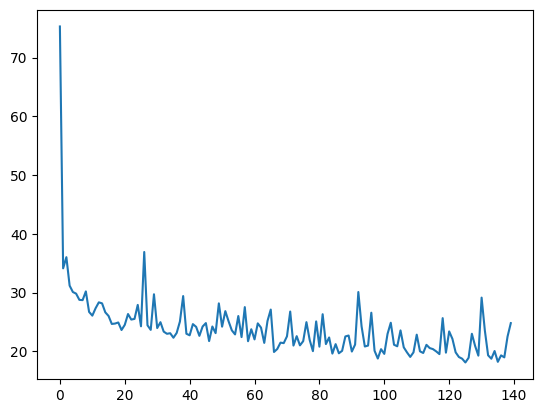

In [37]:
#Best trial config: {'lr': 0.00011600353938883104,
# 'momentum': 0.009328857531182592,
# 'opt_momentum': 0.00918667445141735, 'weight_std': 0.0033244058597709614,
# 'weight_mean': 6.9949608597674535, 'bias_mean': 0.3226930394143123, 'bias_std': 0.012726759642886507,
# 'batch_size': 14, 'epochs': 490, 'dims': [8, 128, 16, 32, 8, 256, 28], 'optimiser':
# 'Adams', 'checkpoint_interval': 10}
# otimiser': 'Adams', 'checkpoint_interval': 10,
# 'opt_momentum': 0.009262583085697922}


model_ = BayesianCNN(num_feature=X_train.shape[1],dims=[512,28,64,128,256],
                       weight_std=4.7621 ,weight_mean=0.0002, bias_mean=0.0003,
                      bias_std=16.738).to("cpu")


model,history,best_mse =train_func(model_,n_epochs=325,batch_size=66, lr=0.00012,optimizer_="Nadam")

In [137]:
#save model
best_model_name = f'mir_sand_model-1.0.1.pt'
torch.save(best_trained_model.state_dict(),os.path.join("../model-store/",best_model_name))

In [43]:
best_model_name = f'mir_sand_model-1.0.1.pt'
best_trained_model=torch.load(os.path.join("../model-store/",best_model_name))

In [44]:
class BayesianCNN(nn.Module):
    def __init__(self, num_feature: int, dims=[512, 28, 64], weight_std=0.001, bias_std=9.5):
        super(BayesianCNN, self).__init__()

        # Define the fully connected layers based on the specified dimensions
        self.fc_layers = nn.ModuleList()
        in_dim = num_feature
        for out_dim in dims:
            self.fc_layers.append(nn.Linear(in_dim, out_dim))
            in_dim = out_dim

        self.fc_out = nn.Linear(in_dim, 1)  # Output layer carbon

        # Update the dimensions of weight_mu and weight_rho to match the output dimension
        self.weight_dim = out_dim
        self.weight_mu = nn.Parameter(torch.Tensor(1, self.weight_dim))
        self.weight_rho = nn.Parameter(torch.Tensor(1, self.weight_dim))

        self.bias_mu = nn.Parameter(torch.Tensor(1))
        self.bias_rho = nn.Parameter(torch.Tensor(1))
        self.weight_std = weight_std
        self.bias_std = bias_std

        # Initialize parameters
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weight means close to zero and standard deviations to be small
        nn.init.normal_(self.weight_mu, mean=0.0002, std=self.weight_std)
        nn.init.normal_(self.weight_rho, mean=0.003, std=self.weight_std)

        # Initialize bias means close to zero and standard deviations to be small
        nn.init.normal_(self.bias_mu, mean=0.0003, std=self.bias_std)
        nn.init.normal_(self.bias_rho, mean=0.004, std=self.bias_std)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input

        # Pass through fully connected layers with specified dimensions
        for fc_layer in self.fc_layers:
            x = F.rrelu(fc_layer(x))

        # Re-parameterization trick for sampling weights
        weight_epsilon = Normal(0, 1).sample(self.weight_mu.size())
        weight_sigma = torch.log(1 + torch.exp(self.weight_rho))
        weight = self.weight_mu + weight_sigma * weight_epsilon

        bias_epsilon = Normal(0, 1).sample(self.bias_mu.size())
        bias_sigma = torch.log(1 + torch.exp(self.bias_rho))
        bias = self.bias_mu + bias_sigma * bias_epsilon

        # Enforce non-negativity on weights and biases
        weight = torch.clamp(weight, min=0)
        bias = torch.clamp(bias, min=0)

        # Final linear layer operation
        output = F.linear(x, weight, bias)
        return output
model = BayesianCNN(num_feature=X_train.shape[1],dims=[8,32,32,256,128,8],
                     weight_std=0.0016,
                      bias_std=0.0015744)
model.load_state_dict(torch.load(os.path.join("../model-store/",best_model_name)))

<All keys matched successfully>

In [23]:
## Testing
model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        X_sample = X_test_raw[i: i+1]
        X_sample = scaler.transform(X_sample)
        X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_pred = model(X_sample)


        print(f"{y_pred.numpy()} (expected {y_test[i].numpy()})")

[[54.779083]] (expected [53.870003])
[[46.121532]] (expected [45.39])
[[43.307953]] (expected [23.483])
[[56.67434]] (expected [49.93])
[[62.604366]] (expected [62.72])


In [38]:
test_result= evaluate_soil_property(model,X_test_raw,sample_size=100)
test_result["obs"] = y_test
test_result['type'] ='Validation'
test_result['variable'] ='sand'
test_result


,lower,upper,pred,obs,type,variable
0,19.448324,42.143402,11.347540,15.559998,Validation,sand
1,17.634136,99.900000,63.645828,45.610001,Validation,sand
2,31.624722,99.900000,72.977654,53.827000,Validation,sand
3,3.390111,4.162225,0.386057,1.070000,Validation,sand
4,10.597329,14.326819,1.864745,4.279999,Validation,sand
...,...,...,...,...,...,...
1000,44.544590,99.900000,82.117462,74.000000,Validation,sand
1001,15.483009,33.049107,8.783049,36.910000,Validation,sand
1002,18.657305,54.610344,17.976519,15.959999,Validation,sand
1003,23.392887,99.900000,68.369049,40.959999,Validation,sand


In [28]:
test_result['pred'].max()


99.2968

In [20]:
train_result= evaluate_soil_property(model,X_train_raw,sample_size=100)
train_result["obs"] = y_train
train_result['type'] =' Calibration'
train_result['variable'] ='sand'
train_result


,lower,upper,pred,obs,type,variable
0,0.959274,5.650571,3.304922,22.489998,Calibration,sand
1,1.112277,5.985457,3.548867,5.209999,Calibration,sand
2,2.546515,9.101615,5.824065,7.209999,Calibration,sand
3,2.923191,9.680145,6.301668,0.010000,Calibration,sand
4,34.322906,40.789925,37.556416,30.489998,Calibration,sand
...,...,...,...,...,...,...
2407,6.211907,14.910117,10.561012,10.630000,Calibration,sand
2408,71.234848,85.172424,78.203636,81.000000,Calibration,sand
2409,26.194210,34.508106,30.351158,31.000000,Calibration,sand
2410,67.621407,81.963005,74.792206,79.489998,Calibration,sand


In [23]:
final_df=pd.merge(train_result,test_result,how="outer")

In [24]:
final_df.to_csv("C:/Projects/ResearchProjects/Research-SoilSpectroscopy/Smap/Models/CNN/Mir/Results/cnn_sand.csv")
final_df

,lower,upper,pred,obs,type,variable
0,0.959274,5.650571,3.304922,22.489998,Calibration,sand
1,1.112277,5.985457,3.548867,5.209999,Calibration,sand
2,2.546515,9.101615,5.824065,7.209999,Calibration,sand
3,2.923191,9.680145,6.301668,0.010000,Calibration,sand
4,34.322906,40.789925,37.556416,30.489998,Calibration,sand
...,...,...,...,...,...,...
3412,56.940807,69.150909,63.045860,74.000000,Validation,sand
3413,45.413712,52.666031,49.039871,36.910000,Validation,sand
3414,27.939157,36.571804,32.255482,15.959999,Validation,sand
3415,48.254234,56.531227,52.392731,40.959999,Validation,sand


In [39]:
import numpy as np

def calculate_pcip(y_true, lower_bounds, upper_bounds):
    num_samples = len(y_true)
    num_covering_intervals = np.sum((lower_bounds <= y_true) & (y_true <= upper_bounds))
    pcip = (num_covering_intervals / num_samples) * 100
    return pcip

pcip = calculate_pcip(test_result['obs'], test_result['lower'], test_result['upper'])
print(f"Prediction Interval Coverage Probability (PCIP): {pcip:.2f}%")

Prediction Interval Coverage Probability (PCIP): 51.24%


In [22]:
#mean predition interval width
def calculate_mpiw(lower_bounds, upper_bounds):
    num_samples = len(lower_bounds)
    num_covering_intervals = np.sum(upper_bounds -lower_bounds)
    mpiw = (num_covering_intervals / num_samples)
    return mpiw

mpiw = calculate_mpiw(test_result['lower'], test_result['upper'])
print(f"Mean Prediction Interval Width (mpiw): {mpiw:.2f}")

Mean Prediction Interval Width (mpiw): 9.15


In [50]:
evaluate(model,X_train_raw,y_train,type="r2")

0.9418567689040978

In [29]:
evaluate(model,X_test_raw,y_test,type="r2")

0.8725837982987219

In [26]:
evaluate(model,X_test_raw,y_test,type="rmse")

9.062159

In [29]:
evaluate(model,X_train_raw,y_train,type="rmse")



7.890963